# Generate caravan Map
In this notebook you will retrieve the geospatial data for the Cravan dataset.The caravan dataset is a collection of streamflow and forcing data. <br>
Caravan was prepared by [Frederik Kratzert](https://doi.org/10.1038/s41597-023-01975-w), the forcing is based on the ERA5-Land model. The streamflow is from the USGS. <br>
To access it easily, it was stored [here](https://doi.org/10.4121/bf0eaf7c-f2fa-46f6-b8cd-77ad939dd350.v4) on the [OPenDAP](https://data.4tu.nl/info/about-your-data/netcdf-and-opendap) server from data.4TU.nl .<br>
This saves you from downloading and reading the whole dataset hosted on [zenodo](https://zenodo.org/records/6578598), instead only the necesarry data is downloaded. 

This notebook will show case how to turn this into an easily accessible map.  

This supplies you with the basin_id.
The shapefiles will be downloaded automatically and the catchment information downloaded from the server


In [1]:
import wget
from zipp import zipfile
from pathlib import Path
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

import requests
from bs4 import BeautifulSoup
import numpy as np

import folium

In [2]:
COMMON_URL = "ca13056c-c347-4a27-b320-930c2a4dd207"
OPENDAP_URL = f"https://opendap.4tu.nl/thredds/dodsC/data2/djht/{COMMON_URL}/1/"
SHAPEFILE_URL = (
    f"https://data.4tu.nl/file/{COMMON_URL}/bbe94526-cf1a-4b96-8155-244f20094719"
)
shape_file_url = SHAPEFILE_URL

In [6]:
out_path = Path('shapefiles')
if not out_path.exists():
    out_path.mkdir()
zip_path = out_path / 'shapefiles.zip'
if not zip_path.is_file():
    wget.download(shape_file_url, out=str(out_path))

In [7]:
combined_shapefile_path = out_path / "combined.shp"
if not combined_shapefile_path.is_file():
    with zipfile.ZipFile(zip_path) as myzip:
        myzip.extractall()

In [8]:
gdf = gpd.read_file(combined_shapefile_path)

In [9]:
dataset_names = list(set(gdf['gauge_id'].apply(lambda x: x.split('_')[0]).values))
dataset_names

['camelsgb', 'camelsbr', 'camelsaus', 'hysets', 'camels', 'lamah', 'camelscl']

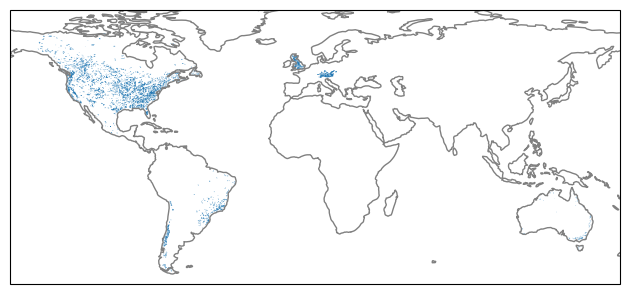

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
gdf.plot(ax=ax,zorder=1,color="C0")
plt.tight_layout()

## Look up availible datasets (redundant)

In [12]:
data = requests.get(f'https://opendap.4tu.nl/thredds/catalog/data2/djht/ca13056c-c347-4a27-b320-930c2a4dd207/1/catalog.html')

In [13]:
html = data.text
table = html[html.find('<table'):html.find("</table>")]

In [14]:
table_data = [[np.array(cell.text.strip()) for cell in row("td")]
                         for row in BeautifulSoup(table)("tr")][2:]

In [15]:
dataset_names = np.array(table_data)[:,0] 
dataset_names = [names[:-3] for names in dataset_names]

In [16]:
dataset_names

['lamah', 'hysets', 'camelsgb', 'camelscl', 'camelsbr', 'camelsaus', 'camels']

# Load data

In [17]:
import xarray as xr

In [18]:
 def get_camels_ids(dataset: str):
    ds = xr.open_dataset(f"https://opendap.4tu.nl/thredds/dodsC/data2/djht/ca13056c-c347-4a27-b320-930c2a4dd207/1/{dataset}.nc")
    return np.array([basin.decode() for basin in ds['basin_id'].values])

In [19]:
 def get_caravan(dataset: str, basin_id: str):
    ds = xr.open_dataset(f"https://opendap.4tu.nl/thredds/dodsC/data2/djht/ca13056c-c347-4a27-b320-930c2a4dd207/1/{dataset}.nc")
    return ds.sel(basin_id=basin_id.encode())

In [20]:
def get_dataset(dataset) -> xr.Dataset:
    """Opens specified dataset from data.4tu.nl OPeNDAP server.
    Args:
        dataset (str): name of dataset, choose from:
            'camels',
            'camelsaus',
            'camelsbr',
            'camelscl',
            'camelsgb',
            'hysets',
            'lamah'
    """
    return xr.open_dataset(f"{OPENDAP_URL}{dataset}.nc")


In [21]:
get_camels_ids(dataset_names[-1])[0]

'camels_01022500'

In [22]:
basin_id="camels_01022500"
ds = get_caravan(dataset_names[-1], basin_id)

In [23]:
PROPERTY_VARS = [
    "timezone",
    "name",
    "country",
    "lat",
    "lon",
    "area",
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    "moisture_index",
    "seasonality",
    "high_prec_freq",
    "high_prec_dur",
    "low_prec_freq",
    "low_prec_dur",
]
RENAME_ERA5 = {
    "total_precipitation_sum": "pr",
    "potential_evaporation_sum": "evspsblpot",
    "temperature_2m_mean": "tas",
    "temperature_2m_min": "tasmin",
    "temperature_2m_max": "tasmax",
    "streamflow": "Q",
}

In [24]:
ds

<xarray.Dataset>
Dimensions:                             (time: 14609)
Coordinates:
  * time                                (time) datetime64[ns] 1981-01-01 ... ...
    basin_id                            |S64 b'camels_01022500'
Data variables: (12/55)
    timezone                            |S64 ...
    name                                |S64 ...
    country                             |S64 ...
    lat                                 float64 ...
    lon                                 float64 ...
    area                                float64 ...
    ...                                  ...
    volumetric_soil_water_layer_2_max   (time) float32 ...
    volumetric_soil_water_layer_3_max   (time) float32 ...
    volumetric_soil_water_layer_4_max   (time) float32 ...
    total_precipitation_sum             (time) float32 ...
    potential_evaporation_sum           (time) float32 ...
    streamflow                          (time) float32 ...
Attributes:
    history:  Wed Mar 27 16:11:00 2024: /usr/bin/ncap2 -s time=double(time) -...
    NCO:      netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, C...

In [25]:
lst_df_info = []
for dataset_name in dataset_names:
    ds = get_dataset(dataset_name)
    variables = ds.data_vars.keys()
    properties = set(variables).intersection(PROPERTY_VARS)
    non_property_vars = set(variables) - properties
    variable_names = non_property_vars.intersection(
        RENAME_ERA5.keys()
    )  # only take the vars also in Rename dict
    ds = ds.drop_vars(non_property_vars)
    ds = ds.drop_indexes("time")
    ds = ds.drop_vars("time")
    ds['basin_id'] = [val.decode() for val in ds['basin_id'].values]
    
    df_info = ds.to_dataframe()
    for val in ['timezone','name', 'country']:
        df_info[val] = df_info[val].apply(lambda x: x.decode('ISO-8859–1'))
    
    lst_df_info.append(df_info)

In [26]:
df_combined_info = pd.concat(lst_df_info).sort_index()

In [27]:
df_combined_info['basin_id'] = df_combined_info.index

In [28]:
if 'gauge_id' in gdf.columns:
    gdf = gdf.set_index('gauge_id')

In [29]:
for val in df_combined_info.keys():
    gdf[val] = df_combined_info[val]

In [30]:
# add to gdf

In [31]:
gdf[['timezone','name','country']]

,timezone,name,country
gauge_id,,,
camels_01022500,America/New_York,"Narraguagus River at Cherryfield, Maine",United States of America
camels_01031500,America/New_York,"Piscataquis River near Dover-Foxcroft, Maine",United States of America
camels_01047000,America/New_York,"Carrabassett River near North Anson, Maine",United States of America
camels_01052500,America/New_York,"Diamond River near Wentworth Location, NH",United States of America
camels_01054200,America/New_York,"Wild River at Gilead, Maine",United States of America
...,...,...,...
lamah_47840,Europe/Berlin,Kanzach at Unlingen,Germany
lamah_76175,Europe/Berlin,Blau at Ulm,Germany
lamah_76176,Europe/Berlin,Eger at Bopfingen,Germany


Turn it into a Map using folium

In [32]:
# control_bool = True
# caravan_map = folium.Map(
#                     # location        = [NL_outline.iloc[0].geometry.centroid.y, NL_outline.iloc[0].geometry.centroid.x],
#                     # zoom_start      = 8,
#                     # zoom_control    = control_bool,
#                     # scrollWheelZoom = control_bool,
#                     # dragging        = control_bool
#                     )

# catchments = gdf.to_crs(epsg=4326)

# folium.features.GeoJson(catchments,).add_to(caravan_map)

In [33]:
# # icon = folium.features.Icon(color="blue",icon="none")

# gjson = folium.features.GeoJson(
#                                 gdf,
#                                 # marker = folium.features.Marker(icon=icon)
#                                 ).add_to(caravan_map)

# # create
# popup = folium.features.GeoJsonPopup(
#     fields=['name','country','basin_id'],

# ).add_to(gjson)

In [35]:
# caravan_map.save(f"caravan_catchments_map.html")

### Too big, split per contry: 

In [36]:
countries = gdf['country'].unique()

In [39]:
import warnings
warnings.simplefilter("ignore") # centroid gives : UserWarning: Geometry is in a geographic CRS

In [44]:
countries

array(['United States of America', 'Australia', 'Brazil', 'Chile',
       'Scotland', 'England', 'Wales', 'Canada', 'Mexico', 'Germany',
       'Switzerland', 'Austria', 'Lichtenstein', 'Czech Republic'],
      dtype=object)

In [ ]:
map_path = Path('docs')
if not out_path.exists():
    out_path.mkdir()

In [46]:
for country in countries:
    gdf_country = gdf[gdf['country'] == country]
    country_map = folium.Map(
                        location        = [np.mean(gdf_country.geometry.centroid.y), np.mean(gdf_country.geometry.centroid.x)],
                        zoom_start      = 6,
                        )

    catchments_country = gdf_country.to_crs(epsg=4326)
    
    folium.features.GeoJson(catchments_country,).add_to(country_map)
    gjson = folium.features.GeoJson(
                                gdf_country,
                                # marker = folium.features.Marker(icon=icon)
                                ).add_to(country_map)

    # create
    popup = folium.features.GeoJsonPopup(
        fields=['basin_id','name','country','area',
       'p_mean', 'pet_mean', 'aridity', 'frac_snow', 'moisture_index',
       'seasonality', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq',
       'low_prec_dur'],
    
    ).add_to(gjson)

    country_map.save(map_path / f"caravan_catchments_map_{country.replace(' ','_')}.html")   

# make links

In [55]:
lst_links = []
for country in countries:
   lst_links.append(f"[{country}](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_{country.replace(' ','_')}.html)<br>")

In [56]:
lst_links

['[United States of America](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_United_States_of_America.html)<br>',
 '[Australia](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Australia.html)<br>',
 '[Brazil](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Brazil.html)<br>',
 '[Chile](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Chile.html)<br>',
 '[Scotland](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Scotland.html)<br>',
 '[England](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_England.html)<br>',
 '[Wales](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Wales.html)<br>',
 '[Canada](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Canada.html)<br>',
 '[Mexico](https://nbviewer.org/gith

[United States of America](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_United_States_of_America.html)<br>
'[Australia](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Australia.html)<br, '[Brazil](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Brazil.html)<b',
 '[Chile](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Chile.html)<>'
 '[Scotland](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Scotland.html)r>,
 '[England](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_England.htmlbr',
 '[Wales](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Wales.htm<b>',
 '[Canada](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Canada.ht)<r>',
 '[Mexico](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Mexico.hl)br>',
 '[Germany](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Germany.ml<br>',
 '[Switzerland](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Switzerlandtm)<br>',
 '[Austria](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Austrihtl)<br>',
 '[Lichtenstein](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Lichtenste.hml)<br>',
 '[Czech Republic](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Czech_Repubc.html)<br>']://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Lichtenstein.html)<br>',
 '[Czech Republic](https://nbviewer.org/github/Daafip/caravan-map/blob/main/docs/caravan_catchments_map_Czech_Republic.html)<br>']

In [57]:
lst_links = []
for country in countries:
   lst_links.append(f"[{country}](caravan_catchments_map_{country.replace(' ','_')}.html)<br>")

In [58]:
lst_links

['[United States of America](caravan_catchments_map_United_States_of_America.html)<br>',
 '[Australia](caravan_catchments_map_Australia.html)<br>',
 '[Brazil](caravan_catchments_map_Brazil.html)<br>',
 '[Chile](caravan_catchments_map_Chile.html)<br>',
 '[Scotland](caravan_catchments_map_Scotland.html)<br>',
 '[England](caravan_catchments_map_England.html)<br>',
 '[Wales](caravan_catchments_map_Wales.html)<br>',
 '[Canada](caravan_catchments_map_Canada.html)<br>',
 '[Mexico](caravan_catchments_map_Mexico.html)<br>',
 '[Germany](caravan_catchments_map_Germany.html)<br>',
 '[Switzerland](caravan_catchments_map_Switzerland.html)<br>',
 '[Austria](caravan_catchments_map_Austria.html)<br>',
 '[Lichtenstein](caravan_catchments_map_Lichtenstein.html)<br>',
 '[Czech Republic](caravan_catchments_map_Czech_Republic.html)<br>']

[United States of America](caravan_catchments_map_United_States_of_America.html)<br>
[Australia](caravan_catchments_map_Australia.html)<br>
[Brazil](caravan_catchments_map_Brazil.html)<br>
[Chile](caravan_catchments_map_Chile.html)<br>
[Scotland](caravan_catchments_map_Scotland.html)<br>
[England](caravan_catchments_map_England.html)<br>
[Wales](caravan_catchments_map_Wales.html)<br>
[Canada](caravan_catchments_map_Canada.html)<br>
[Mexico](caravan_catchments_map_Mexico.html)<br>
[Germany](caravan_catchments_map_Germany.html)<br>
[Switzerland](caravan_catchments_map_Switzerland.html)<br>
[Austria](caravan_catchments_map_Austria.html)<br>
[Lichtenstein](caravan_catchments_map_Lichtenstein.html)<br>
[Czech Republic](caravan_catchments_map_Czech_Republic.html)<br>